## Проект по А/B-тестированию

### Постановка задачи
Провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
Оцените корректность проведения теста
Проанализируйте результаты теста
Чтобы оценить корректность проведения теста, проверьте:
пересечение тестовой аудитории с конкурирующим тестом,
совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание
- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие product_page
    - просмотры корзины — product_cart
    - покупки — purchase.
- Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.

### Цели исследования 
- оценить корректность проведения A/B-теста 
    - проверить пересечение тестовой аудитории с конкурирующим тестом
    - совпадение теста и маркетинговых событий
    - другие проблемы временных границ теста
- проанализировать результаты A/B-теста 

### Загрузка данных, общая информация по датасету и предобработка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import math as mth
from tqdm import tqdm
import pylab

In [2]:
pd.options.display.float_format = '{:.2f}'.format

In [3]:
sns.set_palette('Paired')

In [4]:
try: # локальный путь
    marketing = pd.read_csv('ab_project_marketing_events.csv')
# календарь маркетинговых событий на 2020 год
    users = pd.read_csv('final_ab_new_users.csv') 
# все пользователи, # зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года
    events = pd.read_csv('final_ab_events.csv') 
# все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
    participants = pd.read_csv('final_ab_participants.csv')
# таблица участников тестов.
except FileNotFoundError: # яндексовский путь
    marketing = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    users = pd.read_csv('/datasets/final_ab_new_users.csv')
    events = pd.read_csv('/datasets/final_ab_events.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [5]:
dfs= [marketing, users, events, participants]

In [6]:
marketing.sample(10, random_state=0)

,name,regions,start_dt,finish_dt
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
4,4th of July Promo,N.America,2020-07-04,2020-07-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [7]:
users.sample(10, random_state=0)

,user_id,first_date,region,device
9145,8C07103A3DCCA5CB,2020-12-14,EU,Android
33709,9A7EB0465E2DC590,2020-12-10,CIS,Android
7768,1D400F27F375EDDC,2020-12-14,CIS,PC
54387,006E3D14743030D4,2020-12-13,EU,Android
10017,9A79AAC8B0EA52AE,2020-12-14,EU,Mac
43260,1F0A89BEDF27C7B2,2020-12-18,EU,iPhone
20557,E3B99301A37BF13D,2020-12-08,EU,Android
23921,290CEB7493273316,2020-12-22,EU,Mac
42396,FE5295D0FC122E52,2020-12-18,EU,Android
23699,D20FEC90E48A6ECD,2020-12-15,EU,Android


In [8]:
events.sample(10, random_state=42)

,user_id,event_dt,event_name,details
218582,D6CDDC77A39840F8,2020-12-22 04:00:50,product_page,NaN
204789,E72CAC67E18A2A6B,2020-12-21 11:34:53,product_page,NaN
372358,B628EB26058A769A,2020-12-21 12:47:49,login,NaN
39945,A157AAA506AA21C3,2020-12-21 21:41:19,purchase,4.99
50693,3F0E9ABE2DB30444,2020-12-23 04:37:13,purchase,4.99
73840,6020290DC9E4D2E5,2020-12-12 10:26:37,product_cart,NaN
127010,AFFBA268256F20E7,2020-12-07 20:58:19,product_page,NaN
235668,3D455650DAAA70A2,2020-12-25 08:32:11,product_page,NaN
407827,5820DF4697F38849,2020-12-24 12:53:30,login,NaN
327896,2330AC104C5F5B37,2020-12-17 22:28:06,login,NaN


In [9]:
participants.sample(10, random_state=42)

,user_id,group,ab_test
4084,51B7F3ADA62C28CE,B,recommender_system_test
1570,F36F4FC5A884C3DA,A,recommender_system_test
4525,1BC8D784255D5E67,A,recommender_system_test
3310,FDBCCC4C6B301DA1,A,recommender_system_test
15737,8FF91E21E27A330D,A,interface_eu_test
9875,2DABEB62D0265DF8,A,interface_eu_test
217,5D72D0AEF96C50FD,A,recommender_system_test
1427,5F74508C8CE22365,B,recommender_system_test
13058,29916918AD44D513,A,interface_eu_test
15131,D4F6479E98005BDA,B,interface_eu_test


In [10]:
for df in dfs:
        df.info()
        print("   ")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
   
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
   
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-n

Даты везде требуют преобразования типа данных.

### Предобработка данных

#### Преобразования типа данных

In [11]:
# преобразование данных о времени
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])
users['first_date'] = pd.to_datetime(users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

#### Пропуски

Посмотрим на пропуски.

In [12]:
for df in dfs:
    print(df.isna().mean()) 
    print("   ")

name        0.00
regions     0.00
start_dt    0.00
finish_dt   0.00
dtype: float64
   
user_id      0.00
first_date   0.00
region       0.00
device       0.00
dtype: float64
   
user_id      0.00
event_dt     0.00
event_name   0.00
details      0.86
dtype: float64
   
user_id   0.00
group     0.00
ab_test   0.00
dtype: float64
   


Прорущенные значения имеются только в events (все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года). details (дополнительные данные о событии). B техзадании сказано, что "например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах". Похоже, что оно заполнено как раз только для покупок, а для остальных событий там пропуски. Проверим.

In [13]:
events[events['event_name'] == 'purchase']['details'].isna().sum()

0

У всех покупок есть информация о стоимости, там нет пропусков.

In [14]:
events[events['event_name'] != 'purchase']['details'].count()

0

In [15]:
events[events['details'] != events['details']]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

У остальных трех действий (product_cart, product_page, login) нет дополнительной информации, и там стоят пропуски. Возможно, этот столбец и задумывался как информация только для стоимости покупок, если таковые были. Мы не будем их заменять, чтобы не искажать данные.

#### Дубликаты

In [16]:
for df in dfs:
    print('duplicates:', df.duplicated().sum()) # вывод количества дубликатов

duplicates: 0
duplicates: 0
duplicates: 0
duplicates: 0


Мы ознакомились с данными:

- У нас 4 датасета 
- Мы преобразовали даты в корректный тип данных
- Обнаружены пропуски в датасете events в details (дополнительные данные о событии). Данные есть только для всех покупок, а для остальных событий нет дополнительной информации. Пропуски мы оставили без изменений.
- Дубликатов не было обнаружено

### Исследовательский анализ данных

#### Общая информация

Посмотрим общую информацию о событиях.

In [17]:
print('всего разных видов событий:', events['event_name'].nunique())

всего разных видов событий: 4


In [18]:
print('всего событий:', events['event_name'].count())

всего событий: 440317


In [19]:
print('всего уникальных пользователей:', events['user_id'].nunique())

всего уникальных пользователей: 58703


In [20]:
# минимальная и максимальная дата 
print('минимальная дата событий:', events['event_dt'].min())
print('максимальная дата событий:', events['event_dt'].max())

минимальная дата событий: 2020-12-07 00:00:33
максимальная дата событий: 2020-12-30 23:36:33


Данные у нас с 7 декабря по 30 декабря, а не как указано в описании к данным "все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года". То есть у нас меньше информации, чем предполагалось. Возможно, это связано с ошибкой в выгрузке.

#### Подготовка кумулятивных таблиц 

Объединим датасет по событием с информацией о пользователях. Далее, сделаем срез по аудитории в соответствии с техзаданием, по  региону EU.

In [21]:
total_all = events.merge(users, how='left', on='user_id')

In [22]:
total = total_all[total_all['region']=='EU']

In [23]:
total

,user_id,event_dt,event_name,details,first_date,region,device
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,EU,iPhone
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,EU,Android
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99,2020-12-07,EU,Android
...,...,...,...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN,2020-12-07,EU,Android
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN,2020-12-07,EU,PC
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN,2020-12-07,EU,Android
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN,2020-12-07,EU,iPhone


Посмотрим на датасет с участниками эксперимента и проверим, нет ли пользователей, оказавшихся в разных тестовых группах (помним, что полных дубликатов не было).

In [24]:
participants['user_id'].duplicated().value_counts() 

False    16666
True      1602
Name: user_id, dtype: int64

In [25]:
participants[['user_id', 'group']].duplicated().value_counts() 

False    17442
True       826
dtype: int64

In [26]:
participants[['user_id', 'ab_test']].duplicated().value_counts() 

False    18268
dtype: int64

In [27]:
participants[participants['user_id'].duplicated(keep=False)].sort_values(['user_id'])

,user_id,group,ab_test
17892,001064FEAAB631A1,B,interface_eu_test
235,001064FEAAB631A1,B,recommender_system_test
16961,00341D8401F0F665,A,interface_eu_test
2137,00341D8401F0F665,A,recommender_system_test
8143,003B6786B4FF5B03,A,interface_eu_test
...,...,...,...
5213,FFC53FD45DDA5EE8,B,recommender_system_test
5667,FFED90241D04503F,B,recommender_system_test
14158,FFED90241D04503F,B,interface_eu_test
3448,FFF28D02B1EACBE1,B,recommender_system_test


Получается, что 1602 участника побывали в обоих тестах interface_eu_test и recommender_system_test. То есть имеется пересечение тестовой аудитории с конкурирующим тестом.  
Как плюс, отметим, что нет пользователей, которые бы в рамках одного теста побывали в группах А и B.

Участников обоих тестов нужно будет исключить из анализа результатов, так как участие во втором  тесте могло иметь влияние на результаты по первому. Также оставим только тех, что участвовали в recommender_system_test, результаты которого нас интересуют в данной работе.

In [28]:
# удаление всех пользователей, оказавшихся в обоих тестах
participants_all=participants # оставим копию изначального датасета
participants=participants.drop_duplicates(subset=['user_id'], keep=False)

In [29]:
# оставляем пользователей, оказавшихся в recommender_system_test
participants = participants[participants['ab_test']=='recommender_system_test']
participants.shape

(5099, 3)

Всего в датасете по участникам теста 5099 участников. 

Соединим информацию о тесте с датасетом по событиям и пользователям. Удалим стороки с пользователями, не участвовавшими в тесте recommender_system_test (т.е. те у кого получился NaN в ab_test).

In [30]:
total = total.merge(participants, how='left', on='user_id')
total = total.dropna(subset=['ab_test'])

In [31]:
print('всего уникальных пользователей:', total['user_id'].nunique())

всего уникальных пользователей: 2594


In [32]:
print('всего уникальных пользователей в группе А :', total[total['group']=='A']['user_id'].nunique())

всего уникальных пользователей в группе А : 1939


In [33]:
print('всего уникальных пользователей в группе В :', total[total['group']=='B']['user_id'].nunique())

всего уникальных пользователей в группе В : 655


В итоговой таблице участников стало гораздо меньше, 2594 (не забудем, что мы соединили информацию о тестах для пользователей, который участвовали только в одном тесте - recommender_system_test, с датасетом только по пользователям из Европы, поэтому у нас стало меньше людей) в то время как ожидаемое число участников было 6000.

Заметим, что контрольная и экспериментальная группы не равны. В контрольной - 1939, а в экспериментальной - 655, то есть в три раза меньше участников.

In [34]:
# минимальная и максимальная дата 
print('минимальная дата регистрации:',total['first_date'].min())
print('максимальная дата регистрации:', total['first_date'].max())
# минимальная и максимальная дата 
print('минимальная дата событий:', total['event_dt'].min())
print('максимальная дата событий:', total['event_dt'].max())

минимальная дата регистрации: 2020-12-07 00:00:00
максимальная дата регистрации: 2020-12-21 00:00:00
минимальная дата событий: 2020-12-07 00:16:00
максимальная дата событий: 2020-12-30 06:42:52


Даты регистрации европейских пользователей, участвовавших в эксперименте, совпадают с техзаданием, с 7 по 21 декабря. Период событий - с 7 по 30 декабря, меньше заявленного (с 7 декабря 2020 по 4 января 2021 года).

#### Пользователи по странам

In [35]:
regions=total_all.groupby('region')[['user_id']].agg('nunique').rename(columns={'user_id': 'total_users'})
regions['%']=regions['total_users']/regions['total_users'].sum()*100
regions=regions.sort_values(by='%', ascending=False).reset_index()
regions

,region,total_users,%
0,EU,43396,73.92
1,N.America,9051,15.42
2,CIS,3130,5.33
3,APAC,3126,5.33


In [36]:
print('минимальная дата регистрации:', total_all['first_date'].min())
print('максимальная дата регистрации:', total_all['first_date'].max())

минимальная дата регистрации: 2020-12-07 00:00:00
максимальная дата регистрации: 2020-12-23 00:00:00


В датасете по всем пользователям подавляющее большинство из Европы, 74%, но также есть 15% из Северной Америки и по 5% из СНГ и Азиатско-Тихоокеанского региона. В техзадании сказано, что это зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года, однако мы видим, что на самом деле что регистрации по 23 декабря. Кажется, что данные собраны не совсем аккуратно.

In [37]:
# соединим датасеты так, чтобы получить информацию о всех пользователях, что изначально были в датасете participants
total_all=total_all.merge(participants_all, how='right', on='user_id') 
regions_test=total_all[total_all['ab_test']=='recommender_system_test'].groupby(
    'region')[['user_id']].agg('nunique').rename(columns={'user_id': 'total_users'}).reset_index()

In [38]:
regions_test=regions.merge(regions_test, on='region', how='left', suffixes=('_data', '_test'))
regions_test['%test_from_all']=regions_test['total_users_test']/regions_test['total_users_data']*100
regions_test

,region,total_users_data,%,total_users_test,%test_from_all
0,EU,43396,73.92,3481,8.02
1,N.America,9051,15.42,119,1.31
2,CIS,3130,5.33,30,0.96
3,APAC,3126,5.33,45,1.44


Что касается процента новых пользователей, поучаствовавших в тесте, из Европы их оказалось 8%, а не 15%  как ожидалось от теста. Примерно по проценту пользователей из других регионов также попали в тест, и скорее всего так не было задумано.
Необходимо проверить, не было ли проблем с распределением трафика.

In [39]:
# Код ревьюера
test_name = 'recommender_system_test'

test_participants = participants_all[participants_all['ab_test'] == test_name]
new_users = users[users['user_id'].isin(test_participants['user_id'])].reset_index(drop = True)
events = events[events['user_id'].isin(test_participants['user_id'])].reset_index(drop = True)

In [40]:
# Код ревьюера
report = new_users.groupby('region').agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'Участники'})
report['% участников'] = (report['Участники'] / report['Участники'].sum()).round(2)
report.sort_values(by = 'Участники', ascending = False)

,Участники,% участников
region,,
EU,6351,0.95
N.America,223,0.03
APAC,72,0.01
CIS,55,0.01


In [41]:
eu_test_users = new_users.query('region == "EU"').shape[0]
eu_users = users.query('region == "EU" and first_date >= "2020-12-07 00:00:00" and first_date <= "2020-12-17 06:42:52"').shape[0]
eu_test_users / eu_users

0.21706141699989748

Что касается процента новых пользователей, поучаствовавших в тесте, из Европы их оказалось 22%, а не 15% как ожидалось от теста. Необходимо проверить, не было ли проблем с распределением трафика.

#### Пользователи по времени регистрации

In [42]:
print('максимальная дата событий:', total['event_dt'].max())

максимальная дата событий: 2020-12-30 06:42:52


Так как ожидаемый эффект от теста, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%, необходимо исключить из анализа тех, для кого прошло менее 14 дней со дня регистрации. Наши данные данные заканчиваются 30-ого декабря в 06:42:52, поэтому последний день для регистрации для 14 дней "возраста на сайте" это 17-ое декабря в 06:42:52.

In [43]:
print('всего уникальных пользователей:', total['user_id'].nunique())

всего уникальных пользователей: 2594


In [44]:
print('всего уникальных пользователей, для которых прошло не менее 14 дней со дня регистрации:', total[total['first_date']<='2020-12-17 06:42:52']['user_id'].nunique())

всего уникальных пользователей, для которых прошло не менее 14 дней со дня регистрации: 1591


In [45]:
print('всего пользователей, для которых прошло меньше 14 дней со дня регистрации:', (
    total['user_id'].nunique())-(total[total['first_date']<='2020-12-17 06:42:52']['user_id'].nunique()))

всего пользователей, для которых прошло меньше 14 дней со дня регистрации: 1003


In [46]:
total=total[total['first_date']<='2020-12-17 06:42:52']

In [47]:
print('всего уникальных пользователей в группе А :', total[total['group']=='A']['user_id'].nunique())

всего уникальных пользователей в группе А : 1115


In [48]:
print('всего уникальных пользователей в группе В :', total[total['group']=='B']['user_id'].nunique())

всего уникальных пользователей в группе В : 476


Таким образом, количество пользователей уменьшилось еще больше, и стало равно 1591, количество по группам - в А 1115, в В - 476. Заметим, что итоговые контрольная и экспериментальная группы не равны. 

#### Присутствуют ли в выборках одни и те же пользователи?

Убедимся еще раз, что в выборках пользователи не повторяются.

In [49]:
participants[['user_id', 'group']].duplicated().value_counts() 

False    5099
dtype: int64

Пользователей с одинаковым id и принадлежащим обоим группам не обнаружено.

#### Есть ли в данных ещё какие-то особенности, которые нужно учесть, прежде чем приступать к A/B-тестированию?

#### Cтруктура трафика

Посмотрим на структуру трафика, т.е. с каких устройств приходят пользователи.

In [50]:
device=total[total['group']=='A'].groupby(['group', 'device'])[['device']].agg('count')
device['%device']=device['device']/device['device'].sum()*100
device

device  %device
group device                  
A     Android    3547    43.84
      Mac         754     9.32
      PC         2132    26.35
      iPhone     1657    20.48

In [51]:
device=total[total['group']=='B'].groupby(['group', 'device'])[['device']].agg('count')
device['%device']=device['device']/device['device'].sum()*100
device

device  %device
group device                  
B     Android    1379    47.68
      Mac         236     8.16
      PC          633    21.89
      iPhone      644    22.27

В целом мы можем сказать, что деление трафика выполнено скорее корректно, но в группе B на 4% больше пользователей Android и на 3% меньше PC.

#### Маркетинговые события

Посмотрим, не повлияли ли маркетинговые события на поведения пользователей.

In [52]:
marketing[(marketing['finish_dt'] >= '2020-12-07') & (marketing["regions"].str.contains("EU"))]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Во время теста также была рождественская маркетинговая акция "Christmas&New Year Promo", это могло повлиять на результаты теста.

#### пользователи, у которых нет событий и которые отсуствуют в файле events

In [53]:
users['user_id'].nunique()

61733

In [54]:
events['user_id'].nunique()

3675

В данных о зарегистрированных пользователях почти на 3030 человек больше, чем в данных о событиях. Это может означать, что данные пользователи не совершали никаких действий в  тот период времени, за который у нас данные, либо была ошибка в выгрузке данных. Если мы считаем, что выгрузка была корректна и данные пользователи после регистрации не совершали никаких действий, стоит посмотреть на их характеристики.

In [55]:
inactive=users.merge(events, on='user_id', how='left')
inactive=inactive[inactive['event_name'].isna()]
#inactive=inactive.groupby('user_id').agg({'first_date':'first', 'region':'first', 'device':'first'})
inactive.describe(include=['object'])

,user_id,region,device,event_name
count,58058,58058,58058,0
unique,58058,4,4,0
top,86461FDA42900EBB,EU,Android,NaN
freq,1,42789,25895,NaN


In [56]:
# Все пользователи по региону
users['region'].value_counts(normalize=True)

EU          0.75
N.America   0.15
CIS         0.05
APAC        0.05
Name: region, dtype: float64

In [57]:
# Неактивные пользователи по региону
inactive['region'].value_counts(normalize=True)

EU          0.74
N.America   0.16
CIS         0.05
APAC        0.05
Name: region, dtype: float64

In [58]:
# Все пользователи по устройству
users['device'].value_counts(normalize=True)

Android   0.45
PC        0.25
iPhone    0.20
Mac       0.10
Name: device, dtype: float64

In [59]:
# Неактивные пользователи по устройству
inactive['device'].value_counts(normalize=True)

Android   0.45
PC        0.25
iPhone    0.20
Mac       0.10
Name: device, dtype: float64

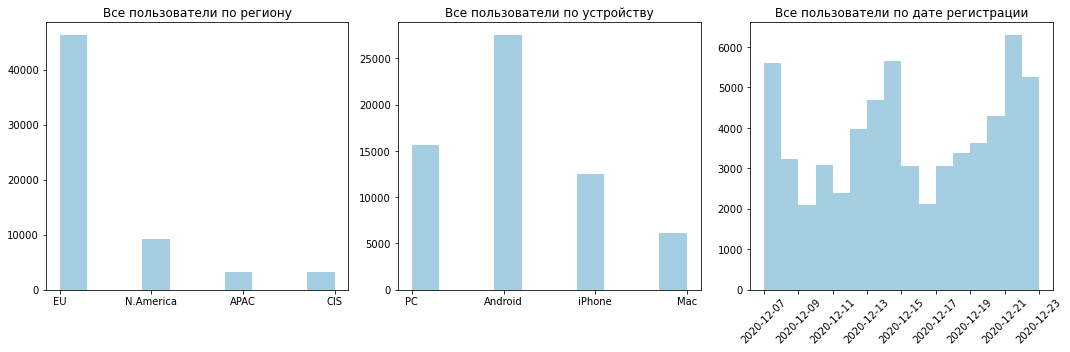

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax[0].set_title('Все пользователи по региону')
ax[0].hist(users['region'])

ax[1].set_title('Все пользователи по устройству')
ax[1].hist(users['device'])


ax[2].set_title('Все пользователи по дате регистрации')
ax[2].hist(users['first_date'], bins=16)
plt.xticks(rotation=45)

fig.tight_layout()

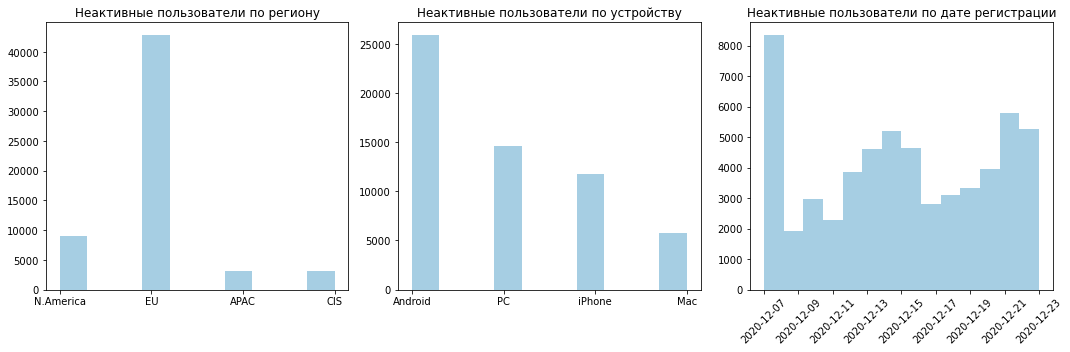

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax[0].set_title('Неактивные пользователи по региону')
ax[0].hist(inactive['region'])

ax[1].set_title('Неактивные пользователи по устройству')
ax[1].hist(inactive['device'])


ax[2].set_title('Неактивные пользователи по дате регистрации')
ax[2].hist(inactive['first_date'], bins=14)
plt.xticks(rotation=45)

fig.tight_layout()

Подавляющее большинство неактивных пользователей, 95% - из Европы, это на 20% больше чем распределение всех пользователей датасета по регионам.  По устройствам распределение такое же как среди всех пользователей: у 45% был Android, PC у 25%, iPhone  й 21%. По датам регистрации- больше всего неактивных пользователей пришло 12-13 декабря, но и в общем в эти даты зарегистрировалось больше людей. Глядя на графики по распределению по датам, нельзя сделать вывод, о связи даты регистрации и неактивности. Плюс у тех, кто зарегистрировался в последние дни было меньше дней, чтобы проявить автивность.

#### Выводы по соответствию техзаданию и по проведению теста

Резюмируем проблемные моменты теста, которые мы уже обнаружили:

- количество участников теста гораздо меньше запланированного: 1591. вместо 6000, это 43% от ожидаемого числа участников. Примерная оценка требуемого объема выборки - 3692 участника в каждой группе. Такое число нужно для обнаружения разницы конверсии в 10% для базовой конверсии в 30% (это примерный результат в контрольной группе по конверсиям в покупку и просмотр корзины), необходимо (https://www.evanmiller.org/ab-testing/sample-size.html#!30;80;5;10;1). Значит, у нас только 22% от необходимого числа участников.
- количество пользователей в группах неравномерно. Группа А (1115) намного больше группы В (476), то есть более чем в 2 раза. В таком случае мы могли бы поделить группу А на две подгруппы и провести АА тест.
- были обнаружены пользователи, участвующие также и в конкурирующем тесте (1602 участника). Они были удалены из датасета для анализа
- информация у нас за меньший период, чем планировалось, с 2020-12-07 по 2020-12-30, вместо по 2021-01-04
- были обнаружены пользователи (1003 человек) , с момента регистрации которых прошло меньше, на анализируемый период (т.е. по 30 декабря). Пользователи, зарегистрировавшиеся после 17 декабря были исключены из анализа.
- внутри выборок распределение событий на пользователей не совсем одинаково, медианное значение в контрольной группе немного больше 
- период теста частично совпадает с рождественской маркетинговой акцией "Christmas&New Year Promo" (с 25 декабря)
- были обнаружены пользователи (3030 человек, это 5% от всех), которые зарегистрировались но не имели ни одного события за рассматриваемый период. Это не влияет на тест, но, возможно требует дальнейшего изучения. Они отличаются от всех пользователей тем, что 95% из них из Европы, при том что в общем у нас 75% пользователей из этого региона

Таким образом, данный тест нельзя назвать корректным, а потому и судить о его репрезентативности.
В проведении теста были допущены критические ошибки, часть из которых мы постарались изолировать в исследовании (удалены пересечение с другим тестом и пользователи, с момента регистрации которых прошло меньше 14 дней), однако это стоило потери большого числа участников, что также негативно для репрезентативных результатов. Мы не можем отделить влияние маркетинговой акции, ни восполнить недостоющее количество участников, ни обеспечить равномерное распределение в группах. Анализ был сделан на имеющемся материале и к его выводам следует отнестись с большой долей сомнения. Чтобы иметь адекватный рещультат теста, необходимо провести тест заново, соблюдая требования к проведению (более подробная рекомендация будет дана в заключении).

### Исследование воронки событий

#### Общая информация по событиям 

In [62]:
df_events=total.groupby('event_name')['event_name'].agg(['count'])
df_events['percent']=df_events['count']/df_events['count'].sum()*100
df_events.sort_values(by='percent', ascending=False)

,count,percent
event_name,,
login,4999,45.52
product_page,3067,27.93
product_cart,1524,13.88
purchase,1392,12.68


Всего по всем действиям видно, что самое популярное с отрывом это просто логин, заход на страницу, это почти половина всех совершенных событий. Потом по популярности идет просмотр карточек товаров, 28%, и далее одинаково около 13% от всех действий это просмотр корзины и сама покупка.

In [63]:
df_events_users=total.groupby('event_name')['user_id'].agg(['nunique'])
df_events_users['percent_from_all']=df_events_users['nunique']/(total['user_id'].nunique()) *100
df_events_users=df_events_users.sort_values(by='percent_from_all', ascending=False)
df_events_users

,nunique,percent_from_all
event_name,,
login,1591,100.00
product_page,988,62.10
product_cart,489,30.74
purchase,465,29.23


У нас 1591 уникальный пользователей, то есть все они как минимум один раз залогинились, что и следовало ожидать.
Второе по популярности действие - product_page, просмотр карточек товаров, совершили 62% пользователей от всех. Довольна большая разница, около 40% пользователей не заходили воообще на страницу с товарами за наблюдаемый период, при этом заходили, чтобы залогиниться.

Покупку, purchase, совершили 29% пользователей, при этом в корзину, product_cart, заходили 31% от всех. Заметим, что воронка непоследовательная и некоторые пользователи пропустили это действие и могли сразу купить товар, не заходя в корзину.

#### Как число событий распределено по дням?

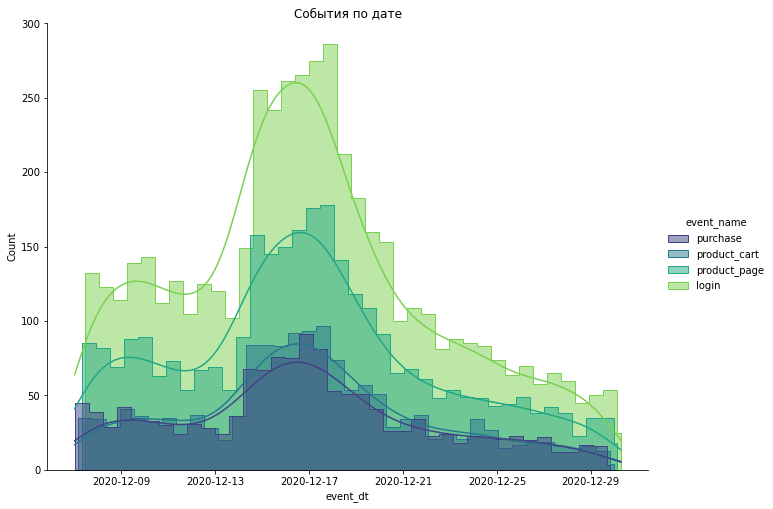

In [64]:
sns.displot(
    total, x=total['event_dt'], hue=total['event_name'], kde=True, palette="viridis", aspect=11./8.27,  height=7, element="step", multiple="dodge", alpha=0.5 ).set(title="События по дате"); 

На графике мы наблюдаем всплеск активности по всем событиям с 15 декабря с пиком 18 ого декабря, это было перед началом рождественской недели в Европе. Далее наблюдается резкое и постоянное падение.

#### Как число событий распределено по дням в зависимости от групп

Посмотрим теперь на эти данные по группам теста.

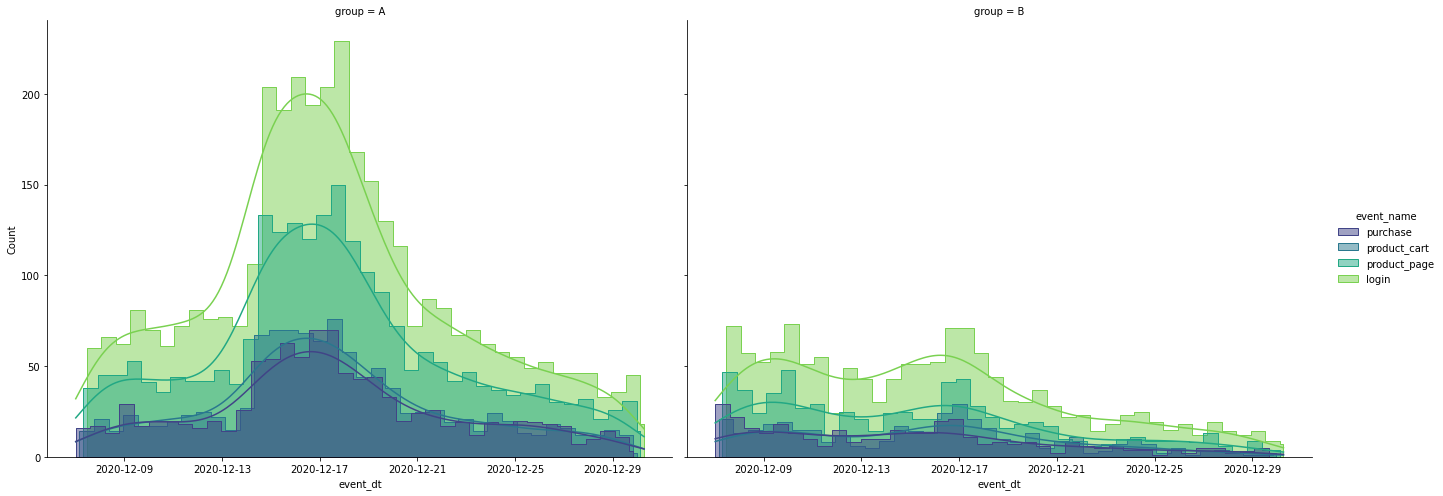

In [65]:
sns.displot(
    total, x=total['event_dt'], hue=total['event_name'], col="group", kde=True, palette="viridis", aspect=11./8.27, element="step", multiple="dodge", alpha=0.5 , height=7); 

На графике по группам видно, что динамика количество событий по дням в экспериментальной группе не испытывала такого резкого роста с 13 и всплеска событий около 18 декабря, график меньше меняется со временем, но в нем тоже наблюдается спад после 18-ого.

#### Конверсия в воронке на разных этапах

При анализе воронки мы будем рассматривать обычную конверсию (в том числе т.к. некоторые шаги воронки могут быть пропущены), а не конверсию из одного шага в другой. Таблица с общей конверсией по уникальным пользователям выглядит так:

In [66]:
df_events_A=total[total['group']=='A'].groupby('event_name')['user_id'].agg(['nunique']).reset_index()
df_events_A['percent_from_all']=df_events_A['nunique']/(total[total['group']=='A']['user_id'].nunique()) *100
df_events_A

df_events_B=total[total['group']=='B'].groupby('event_name')['user_id'].agg(['nunique']).reset_index()
df_events_B['percent_from_all']=df_events_B['nunique']/(total[total['group']=='B']['user_id'].nunique()) *100

convers=df_events_A.merge(df_events_B, how='left', on='event_name', suffixes=('_A', '_B'))
convers = convers.reindex([0,2,1,3]).reset_index(drop=True)
convers

,event_name,nunique_A,percent_from_all_A,nunique_B,percent_from_all_B
0,login,1115,100.00,476,100.00
1,product_page,723,64.84,265,55.67
2,product_cart,350,31.39,139,29.20
3,purchase,333,29.87,132,27.73


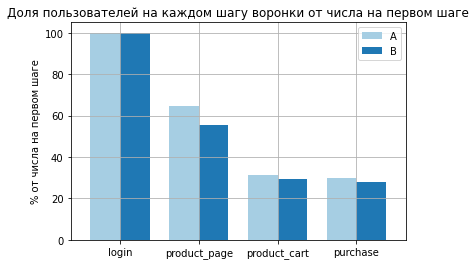

In [67]:
convers.drop(['nunique_A','nunique_B'], axis=1).plot.bar(
    grid=True, title="Доля пользователей на каждом шагу воронки от числа на первом шаге", x='event_name', width = 0.75, rot=0 )
plt.xlabel('')
plt.ylabel('% от числа на первом шаге')
plt.legend (['А', "В"]);

Видим, что в группе B конверсия по уникумам несколько ниже на каждом этапе воронки (сравниваем каждый раз с первым этапом, так как события в воронке можно пропускать), а по product_page конверсия ниже почти на 10%, чем у А. Просмотр корзины и покупка у B ниже на ниже на 2%.  Пока мы можем сказать, чтобы ожидания по эксперименту скорее не оправданы.

#### Обладают ли выборки одинаковыми распределениями количества событий на пользователя?

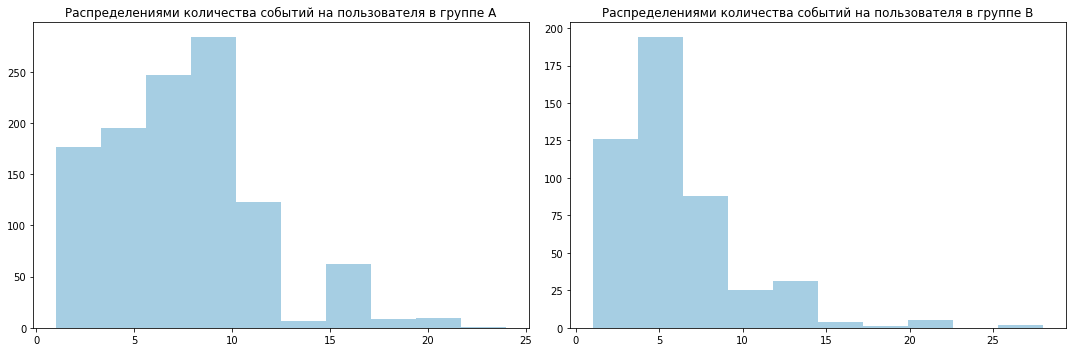

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].set_title('Распределениями количества событий на пользователя в группе А')
ax[0].hist(total[total['group']=='A'].groupby('user_id')['event_name'].agg(['count']))

ax[1].set_title('Распределениями количества событий на пользователя в группе В')
ax[1].hist(total[total['group']=='B'].groupby('user_id')['event_name'].agg(['count']))
fig.tight_layout()

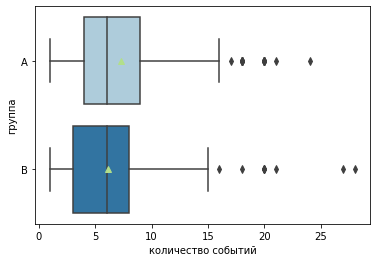

In [69]:
gr=total.groupby('user_id')[['event_name', 'group']].agg({'event_name':'count', 'group':'first'})
sns.boxplot(data=gr, x=gr['event_name'], y=gr['group'], showmeans=True)
plt.xlabel('количество событий')
plt.ylabel("группа")
plt.show()

Выборки распределены не совсем одинаково. Среднее число событий на пользователя в группе А выше, около 7, в В около 6, медианные близки к 6. По группе А в целом чуть большинстве событий. А вот выбросов чуть больше в группе В, там есть люди с очень большим числом событий (больше 25).

### Оценка результатов A/B-тестирования

#### Проверка статистической разницы долей z-критерием

Сводная таблица конверсий:

In [70]:
convers_reset=convers.set_index('event_name').drop(['percent_from_all_A','percent_from_all_B'], axis=1)
convers_reset

,nunique_A,nunique_B
event_name,,
login,1115,476
product_page,723,265
product_cart,350,139
purchase,333,132


Проверим, находят ли статистические критерии разницу между контрольной и экспериментальной группой (А/В).
Наша нулевая гипотеза будет звучать как на каждом шаге "между конверсиями (долями) нет разницы". То есть нет статистически значимой разницы между долями группы А и В:

- 1) тех, кто перешел на страницу с товарами (product_page) к общему количеству пользователей в группе (те кто были на начальной странице) 
- 2) тех кто перешел на страницу с корзиной (product_cart), к общему количеству пользователей в группе 
- 3) тех, кто совершил покупку (purchase) к общему количеству пользователей в группе

Альтернативная гипотеза, соответственно будет звучать, как есть статистически значимая разница между долями в группах по каждой из конверсий.

Для проверки гипотез о конверсии, нам нужно сделать 3 сравнения, проводимых на одних и тех же данных — это множественный тест.

Вероятность того, что хотя бы в одном из трёх сравнений будет зафиксирован ложнопозитивный результат равна при выбранном уровне значимости, равный 0.05 :

In [71]:
1-(1-0.05)**3

0.1426250000000001

Это вероятность того, что хотя бы в одном из трёх попарных сравнений будет зафиксирован ложнопозитивный результат равна, или групповая вероятность ошибки первого рода. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим метод корректировки уровня значимости поправка Бонферрони. Для этого делят уровень значимости на число гипотез, в нашем случае 0.05/3.

In [72]:
alpha =0.05/3 # уровень статистической значимости с поправкой Бонферрони

In [73]:
# создадим фунцию
def test(df, group_a, group_b, event):
    # пропорция успехов в первой группе:
    p1 = df[group_a][event]/df[group_a]['login'] 
    # пропорция успехов во второй группе:
    p2 = df[group_b][event]/df[group_b]['login'] 
    # пропорция успехов во второй группе:
    p_combined = (df[group_a][event] + df[group_b][event]) / (df[group_a]['login'] + df[group_b]['login'])
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / df[group_a]['login'] + 1 / df[group_b]['login']))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

- Конверсия тех, кто перешел на страницу с товарами (product_page):

In [74]:
test(convers_reset, 'nunique_A', 'nunique_B', 'product_page')

p-значение:  0.0005552296307800297
Отвергаем нулевую гипотезу: между долями есть значимая разница


Между группами есть значимая разница по конверсии в переход на страницу с товарами. При этом, у контрольной группы конверсия выше (см. таблицу и графиик "Доля пользователей на каждом шагу воронки от числа на первом шаге" в разделе "Конверсию в воронке на разных этапах").
Таким образом, что мы получили обратный ожидаемому эффект: в тестовой группе конверсия в просмотр карточек товаров значимо ниже.

- Конверсия тех, кто перешел на страницу с корзиной (product_cart):

In [75]:
test(convers_reset, 'nunique_A', 'nunique_B', 'product_cart')

p-значение:  0.3863258273896266
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между группами нет значимой разницы по конверсии в переход на страницу с корзиной. 

- Конверсия тех, кто совершил покупку (purchase):

In [76]:
test(convers_reset, 'nunique_A', 'nunique_B', 'purchase')

p-значение:  0.391367532740043
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между группами нет значимой разницы по конверсии в совершение покупки.

Таким образом, результаты A/B-тестирования показали значимую разницу между конверсиями только при переходе на страницу с товарами, и к тому же в пользу группы А.

## Выводы

#### Оценка корректности проведения A/B-теста

В проведении теста мы обнаружили ряд проблемных моментов, которые могли непосредственно повлиять на его результат, а именно:

- Данные за более короткий период, чем планировалось. Период событий - с 7 по 30 декабря, это меньше заявленного с 7 декабря 2020 по 4 января 2021 года.
- Меньшее число участников, 1591, в то время как ожидаемое число участников было 6000.
- Пересечение тестовой аудитории с конкурирующим тестом (1602 участника, они были удалены из для анализа теста)
- Пересечение теста с рождественской маркетинговой акцией "Christmas&New Year Promo"
- Контрольная и экспериментальная группы не равны. В контрольной - 1115, а в экспериментальной - 476
- Обнаружены пользователи (1003 человек), с момента регистрации которых прошло меньше 14 дней на анализируемый период (т.е. по 30 декабря). Пользователи, зарегистрировавшиеся после 17 декабря были исключены из анализа.
- Неравномерная пользовательская активность в течение наблюдаемого периода, связанная с таким уникальным событием, как рождественские праздники в Европе
- Выборки распределены не совсем неодинаково, в контрольной группе на участника в среднем приходится больше событий. В тестовой группе больше выбросов.
Таким образом, тест был проведен некорректно и мы не можем доверять его результатам.

Также были обнаружены пользователи (3030 человек, это 5% от всех), которые зарегистрировались но не имели ни одного события за рассматриваемый период. 95% из них из Европы, при том что в общем у нас 75% пользователей из этого региона. Это не влияет на тест, но, возможно, требует дальнейшего изучения. 

#### Выводы по результатам A/B-тестирования

По тем результатам теста, что мы получили, мы можем заключить, что ожидания по эксперименту не оправданы. 
- В тестовой группе B пользователи не показали улучшения метрик ни на одном из этапов конверсии. 
- В случае конверсии в переход на страницу с товарами, между группами есть обнаружилась значимая разница. Однако, мы получили обратный ожидаемому эффект: в тестовой группе конверсия в просмотр карточек товаров значимо ниже.

Однако, как было сказано выше, при проведении теста были допущены ошибки, поэтому мы не можем полагаться на выводы из некорректно выполненного теста.

#### Рекомендации:

Для получения валидных результатов, необходимо провести повторный тест с соблюдением всех правил для A/B-тестирования. Необходимо обеспечить:
- корректное деление трафика теста, доли в группах должны быть равные (теоретически тест возможен и с неравными долями, но это гораздо сложнее)
- число участников должно быть больше. Например, для обнаружение разницы конверсии в 10% для базовой конверсии в 30% (ориентируемся здесь на полученный результат в контролькной группе по конверсиям в покупку и просмотр корзины), необходимо 3692 участника в каждой группе (https://www.evanmiller.org/ab-testing/sample-size.html#!30;80;5;10;1) (а у нас оказалось только 22% от необходимого числа участников)
- аудитория теста не должна участвовать одновременно в конкурирующих тестах
- период теста не должен попадать на время, когда возможны другие события или маркетинговые акции, которые окажут влияние на тест
- адекватный период теста (зная трафик и сколько участников из всех посетителей будут участвовать в тесте, длительность можно рассчитать здесь https://vwo.com/tools/ab-test-duration-calculator/)